In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from keras.callbacks import Callback
from keras.utils import to_categorical
from keras.models import load_model
from src.dataset_builders.cnn_rnn_data import CnnRnnData
from src import cnn_rnn as nn

def show(arr):
    plt.imshow(arr, cmap="gray")
    plt.show()


class TrainingPlot(Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

/Users/i862304/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Create a training set from MNIST data

In [2]:
path_model = "../data/cnn_rnn_128_noise_padded.h5"
(x_train, y_train), (x_test, y_test) = CnnRnnData().noise_padded_data

[4 6]


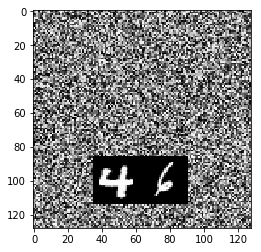

[0 1]


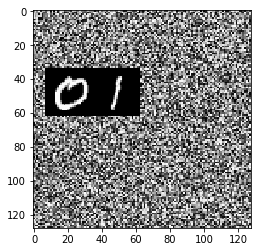

[2 0]


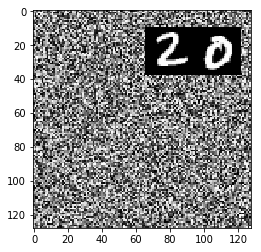

In [3]:
N = 3000

x_train = x_train[:N]
y_train = y_train[:N]
x_test = x_test[:N]
y_test = y_test[:N]

for ii, im in enumerate(x_test[:3]):
    print(y_test[ii])
    show(im)

# Load Experimental Settings

In [4]:
# from src.nn_settings.cnn_rnn_config import Config
from src.nn_settings.cnn_rnn_config import CnnRnnConfig

# keras_shape = (-1, 28, 56, 1)
keras_shape = (-1, 128, 128, 1)
input_encoding = x_train.reshape(keras_shape)
output_encoding = to_categorical(y_train)

num_epochs = 200
batch_size = 32
validation_split = 0.1

cnf = CnnRnnConfig(
            input_shape = (None, 128, 128, 1), 
            output_size = 10,        # num possible outputs from rnn (out vocab size)
            max_out_seq_len  = 2, 
            use_gru = True, 
            latent_dim = 16, 
            use_bidirectional = False, 
            unroll = False, 
            cnn_part=3, # 2, 
        )
cnf = cnf._asdict()

print(input_encoding.shape)
for kk, vv in cnf.items():
    print("\t", kk, ":", vv)

(3000, 128, 128, 1)
	 input_shape : (None, 128, 128, 1)
	 output_size : 10
	 max_out_seq_len : 2
	 use_gru : True
	 latent_dim : 16
	 use_bidirectional : False
	 unroll : False
	 cnn_part : 3


# Load the Model

In [5]:
LOAD = False
if LOAD:
    model = load_model(path_model)
else:
    model = nn.cnn_rnn(**cnf)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

# Train!

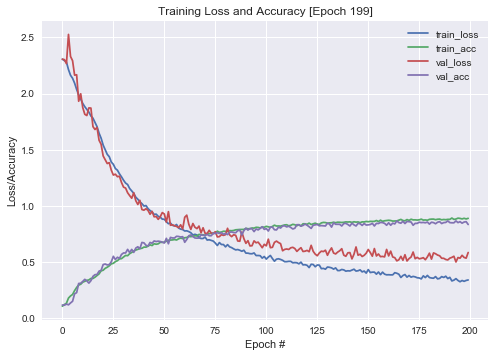

In [6]:
plot_losses = TrainingPlot()

hist = model.fit(input_encoding, 
                  output_encoding,
                  batch_size=batch_size,
                  epochs=num_epochs,
                  validation_split=validation_split,
                  callbacks=[plot_losses]
                 )